# Introduction to Stable Diffusion 

## Generate image from text

In [ ]:
# install diffusers
%pip install -U diffusers

In [1]:
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype = torch.float16
).to("cuda:0")

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


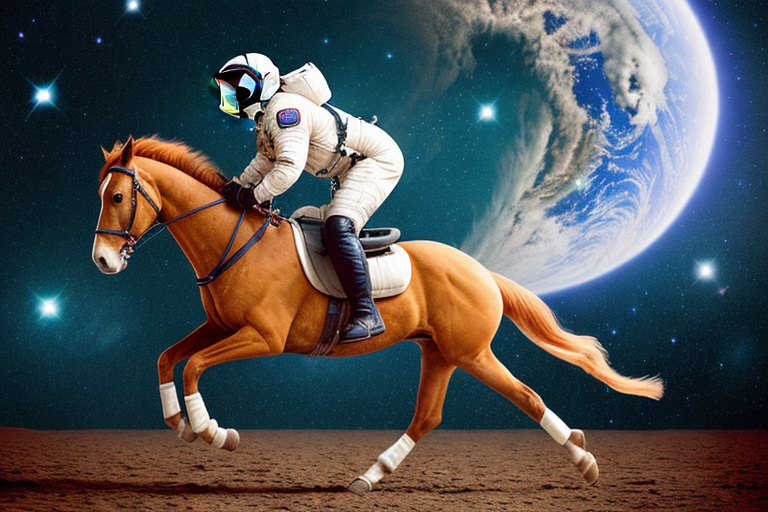

In [2]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(
    prompt          = prompt
    , generator     = torch.Generator("cuda:0").manual_seed(6)
    , width         = 768
    , height        = 512
).images[0]
display(image)

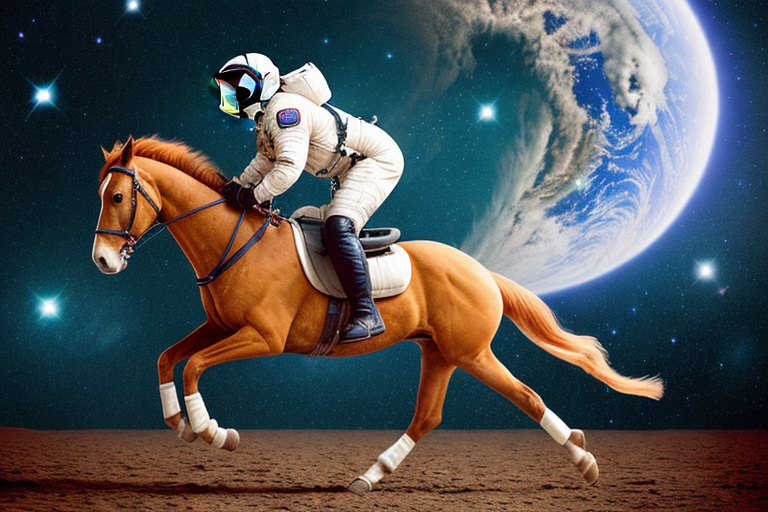

In [3]:
image

## Detect the backgroud

In [4]:
from transformers import CLIPSegProcessor,CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)

Unused or unrecognized kwargs: padding.


torch.Size([352, 352])


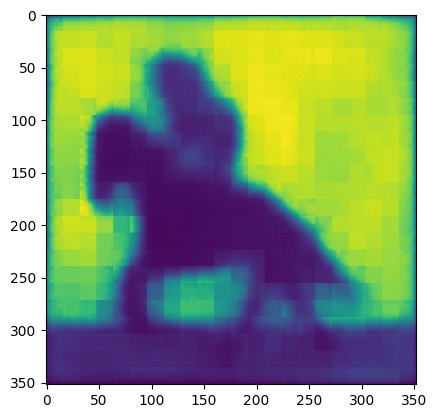

In [6]:
# generate mask data
import matplotlib.pyplot as plt
prompts = ['the background']
inputs = processor(
    text             = prompts
    , images         = [image] * len(prompts)
    , padding        = True
    , return_tensors = "pt"
)

with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits

mask_data = torch.sigmoid(preds)[0]
print(mask_data.shape)
plt.imshow(mask_data)

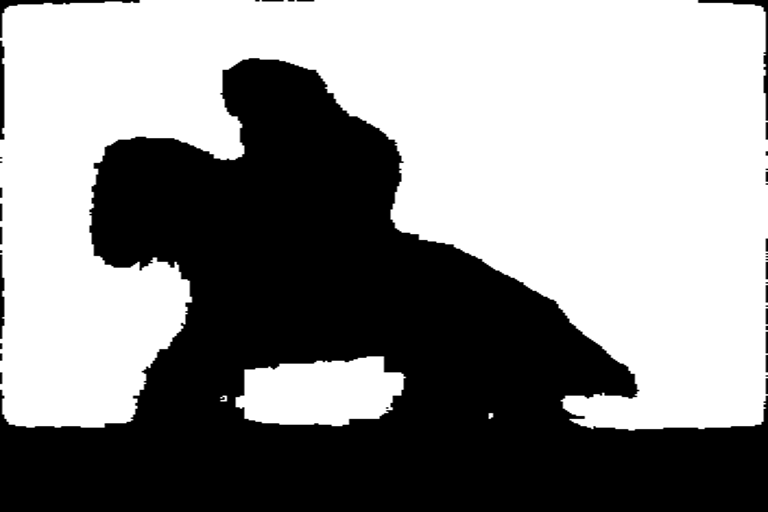

In [7]:
# genearte mask binary image
import cv2
from PIL import Image
mask_file_name = f"bg_mask.png"
plt.imsave(mask_file_name,mask_data) 
mask_data_cv = cv2.imread(mask_file_name) # -> (352, 352, 3)

def get_mask_img(mask_data):
    gray_image = cv2.cvtColor(mask_data,cv2.COLOR_BGR2GRAY)
    thresh, bw_image = cv2.threshold(gray_image,100,255,cv2.THRESH_BINARY)
    cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(bw_image)

bw_image = get_mask_img(mask_data=mask_data_cv)
#cv2.imwrite(bw_image)
bw_image = bw_image.resize((768,512))
bw_image

In [8]:
# Start a inpaint pipeline
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4"
    , torch_dtype = torch.float16
    , safety_checker = None
).to("cuda:0")
#inpaint_pipe.scheduler = EulerDiscreteScheduler.from_config(inpaint_pipe.scheduler.config)

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:749: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable 

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/diffusers/pipelines/deprecated/stable_diffusion_variants/pipeline_stable_diffusion_inpaint_legacy.py:141: FutureWarning: The class <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0. You can achieve exactly the same functionalityby loading your model into `StableDiffusionInpaintPipeline` instead. See https://github.com/huggingface/diffusers/pull/3533for more information.
  deprecate("legacy is outdated", "1.0.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable 

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/45 [00:00<?, ?it/s]

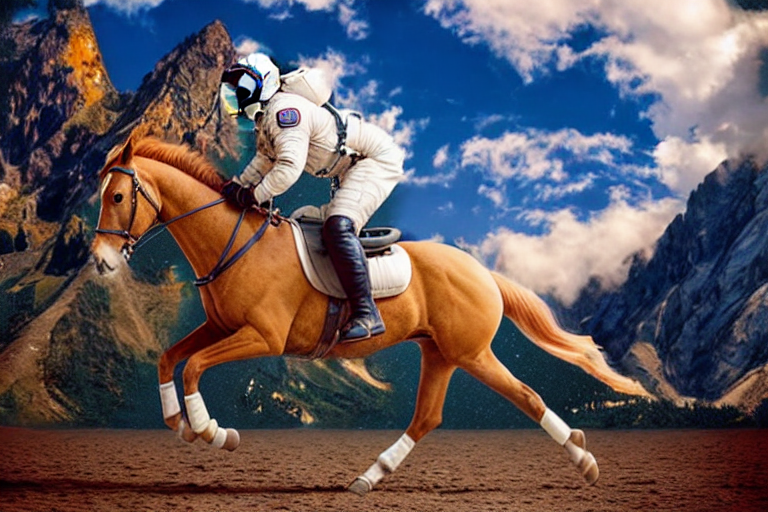

In [9]:
# change the background
sd_prompt = "blue sky and mountains"
out_image = inpaint_pipe(
    prompt          = sd_prompt
    , image         = image
    , mask_image    = bw_image
    , strength      = 0.9
    , generator     = torch.Generator("cuda:0").manual_seed(7)
    # , guidance_scale = 7.5
    # , num_inference_steps = 50
    # , width = 768
    # , height = 512
).images[0]
out_image